# Novelty

In [1]:
from koselleck import *

In [9]:
def get_novelty(words,interpolate=True,by_word=True, **y):
    words=tokenize_fast(words) if type(words)==str else words
    if by_word:
        odf=pd.concat(
            test_novelty(
                get_historical_semantic_distance_matrix(
                    word,
                    interpolate=interpolate
                ),
                **y
            ).assign(word=word)
            for word in words
        )
    else:
        distdf=get_historical_semantic_distance_matrix(words,interpolate=interpolate)
        odf=test_novelty(distdf,**y)
    odf['period']=[int(x[:4]) for x in odf.period]
    return odf

In [3]:
get_novelty('virtue,value')

,period,foote_novelty,foote_size,p_peak,p_trough,word
0,1720,0.000000,2,1.00,0.99,virtue
1,1725,0.000000,2,1.00,0.99,virtue
2,1730,143.898693,2,0.01,1.00,virtue
3,1735,41.307637,2,1.00,1.00,virtue
4,1740,7.711287,2,1.00,1.00,virtue
...,...,...,...,...,...,...
235,1935,0.000000,6,1.00,0.99,value
236,1940,0.000000,6,1.00,0.99,value
237,1945,0.000000,6,1.00,0.99,value
238,1950,0.000000,6,1.00,0.99,value


In [4]:
get_novelty('station', by_word=False)

,period,foote_novelty,foote_size,p_peak,p_trough
0,1720,0.000000,2,1.0,0.99
1,1725,0.000000,2,1.0,0.99
2,1730,73.954047,2,1.0,1.00
3,1735,44.802369,2,1.0,1.00
4,1740,54.499230,2,1.0,1.00
...,...,...,...,...,...
235,1935,0.000000,6,1.0,0.99
236,1940,0.000000,6,1.0,0.99
237,1945,0.000000,6,1.0,0.99
238,1950,0.000000,6,1.0,0.99


## Plotting

In [5]:


def get_plot_novelty_figdf(novdf):
    figdf=novdf.sample(frac=1)
    ywl=[
        f'{x} years'
        for x in figdf['foote_size']*5*2
    ]
    ywls=set(ywl)
    ywll=list(reversed(sorted(list(ywls))))
    figdf['year_window']=pd.Categorical(ywl, categories=ywll)
    figdf['glen']=1
    figdf['is_signif']=pd.Categorical(
        [bool(x<0.05) for x in figdf.p_peak],
        categories=[True,False]
    )
    figdf = pd.concat(
        grp.assign(foote_novelty_z=grp.foote_novelty.apply(lambda x: (x-grp.foote_novelty.mean())/grp.foote_novelty.std()))
        for i,grp in figdf.groupby('foote_size')
    )
    return figdf.dropna().sort_values(['year_window','period'])


# @interact
def plot_novelty(
        words=None,
        novdf=None,
        color='factor(year_window)',
        group='factor(year_window)',
        shape='factor(year_window)',
        size='glen',
        max_p_peak=None,
        vnum='v9',
        showdata=False,
        xlab='Date of semantic model',
        ylab='Foote Novelty (standardized)',
        colorlab='Foote matrix width',
        shapelab='Foote matrix width',
        sizelab='Number of significant peaks',
        title='Average novelty score for significant words over time',
        rolling=2,
        min_periods=1,
        min_foote_size=6,
        max_foote_size=6,
        y='foote_novelty',
        ymin=-.1,
        ylim0=0,
        ylim1=20,
        use_ylim=False,
        xlim0=1750,
        xlim1=1900,
        sizemin=.25,
        sizemax=2,
        labsize=6,
        hline='',
        nudge_label_y=1,
        ymin_heatmap=1750,
        combine=False,
        use_color=False,
        h_fig1=4.00,
        h_fig2=4.00,
        nudge_x=3,
        xlab_min=1735,
        add_median=True,
        save=False,
        label_words=False,
        logy=False,
        show_period_labels=True,
        dist_invert_fill=False,
        line_size=0.5,
        label_size=7,
        ):

    if novdf is None:
        if words is None: return
        novdf = get_novelty(words)
        
    figdf=get_plot_novelty_figdf(novdf.query(f'{min_foote_size}<=foote_size<={max_foote_size}'))
    if not len(figdf): return
    if max_p_peak: figdf=figdf[figdf.p_peak<max_p_peak]
    figwords=set(figdf.word)
    
    
    figdf=figdf.sort_values('period')
#     display(figdf)
    if showdata: display(figdf)
#     print(f'y = {y}')
    fig=start_fig(
        figdf,
        x='period',
        y=y,
        color=color if color else None,
        group=group if group else None,
        figure_size=(8,h_fig1)
    )
    
    if add_median:
        kname='Guides'
        mediandf=pd.DataFrame([{
            'yintercept':figdf[y].median(),
            kname:'Median',
        },
#         {
#             'yintercept':0,
#             kname:'Zero novelty'
#         }
        ])
        fig+=p9.geom_hline(
            p9.aes(yintercept='yintercept',linetype=kname),
            data=mediandf,
            size=.25,
            show_legend=True
        )
        #fig+=p9.geom_text(inherit_aes=False,y=figdf[y].median()+.1,x=xlab_min,size=6,alpha=.8,ha='center',label='Median')
    
            
    fig+=p9.geom_line(size=line_size)
    pntd={}
    if size: pntd['size']=size
    if shape: pntd['shape']=shape
    fig+=p9.geom_point(p9.aes(**pntd))
    # fig+=p9.geom_smooth()
#     fig+=p9.scale_color_distiller()
    
    
    fig+=p9.labs(x=xlab,y=ylab,title=title,color=colorlab,size=sizelab,shape=shapelab)
    if use_ylim: fig+=p9.ylim(ylim0,ylim1)
#     fig+=p9.xlim(xlim0,xlim1)
    fig+=p9.scale_size_continuous(range=(sizemin,sizemax))
    if not use_color: fig+=p9.scale_color_gray(direction=1)# if not use_color else p9.scale_color_distiller(type='qual')
    if hline not in {None,''}:
        fig+=p9.geom_hline(yintercept=hline,linetype='dotted')
#     fig+=p9.geom_smooth(p9.aes(x='year',y=y),inherit_aes=False)

    if words and label_words:
        labeldf=figdf[figdf.is_signif==1]
        grps=[
            grp.sort_values(y).iloc[-1:]
            for i,grp in labeldf.groupby('word')
        ]
        if len(grps):
            labeldf=pd.concat(grps)
            labeldf[y]+=nudge_label_y
            fig+=p9.geom_label(p9.aes(label='word'),color='black',
                               size=label_size,data=labeldf,boxcolor=(0,0,0,0))


    if show_period_labels:
        fig+=p9.geom_vline(xintercept=1770,linetype='dotted',alpha=0.5) 
        fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
        fig+=p9.geom_vline(xintercept=1830,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1750,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1850,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1789,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1815,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1848,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1830,linetype='dashed')
#     if False:
        fig+=p9.geom_label(label='Sattelzeit begins (1770)',x=1770+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0))
        fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
#         fig+=p9.geom_label(label='French Rev. (1789)',x=1789+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
#         fig+=p9.geom_label(label='Peak semantic change (1815)',x=1815+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
#         fig+=p9.geom_label(label='Revolutions of 1848',x=1848+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
    
    
    

    
    
#     fig+=p9.geom_vline(xintercept=1789,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1815,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1830,linetype='dashed')
    

#     xlim0,xlim1=figdf.year.min()//10*10,figdf.year.max()
    if size=='is_signif':
        fig+=p9.scale_size_manual({True:2,False:.2})
    else:
        fig+=p9.scale_size_continuous(range=[.25,3])
#     fig+=p9.scale_x_continuous(breaks=10)
    fig+=p9.theme_minimal()
    fig+=p9.theme(axis_text_x=p9.element_text(angle=90), text=p9.element_text(size=8))
#     if not use_ylim:
#         ylim0=figdf[y].dropna().min()
#         ylim1=figdf[y].dropna().max()
    if logy: fig+=p9.scale_y_log10(limits=[ylim0,ylim1])
        
    
    
    
    #fig+=p9.scale_fill_gray()
    fig+=p9.scale_x_continuous(
        minor_breaks=list(range(xlim0//5*5,(xlim1//5*5)+5,5)),
        limits=[xlim0,xlim1]
    )
#     fig+=p9.xlim(xlim0,xlim1)
    wkey=''
    if words: wkey=words.replace(' ','') if type(words)==str else '-'.join(words)
    ofn=f'''fig.footenov.{vnum}.{wkey+'.' if wkey else ''}{'cmbo.' if combine else ''}png'''
    ofnfn=os.path.join(PATH_FIGS,ofn)

    if combine:
        yymin1=figdf.period.min()
        yymax1=figdf.period.max()
        figdm=plot_historical_semantic_distance_matrix(words=figwords,ymin=xlim0,ymax=xlim1)
        ofig=combine_plots(figdm,fig,ofn=ofnfn)
    else:
        ofig=fig
        if save: ofig.save(ofnfn)
    display(ofig)
    if save: upfig(ofnfn)

In [6]:
def plot_novelty_all(words,**y):
    title=f'Foote Novelty scores for ‘{words}’, 1740-1875 (BPO)'
    return show_novelty(**{
        **dict(
            words=words,
            min_foote_size=4,
            max_foote_size=6,
            rolling=1,
            max_p_peak=0,
            vnum='v26',
            xlim0=1720,xlim1=1900,
            save=SAVE,
            title=title,
            size='is_signif',
            sizelab='Statistically signif.',
            dist_invert_fill=False,
            ylab='Foote Novelty',
            ylim1=-3
        ),
        **y
    })


In [7]:
def plot_novelty_words(words,**kwargs):
    inpd=dict(
        y='foote_novelty_z',
        words=words,
        color='word',
        group='word',
        shape='word',
        colorlab='Word',
        shapelab='Word',
        sizelab='Statistically significant',
        title='Novelty scores for key words',
        ylab='Foote Novelty score',
        size='is_signif',
        vnum='v19',
        use_ylim=False,
        add_median=True,
        max_p_peak=0.0,
        min_foote_size=5,
        max_foote_size=5,
        showdata=False,
        nudge_x=2,
        logy=False,
        ylim0=0,
        ylim1=10,
        xlim0=1745,
        xlim1=1870,
        rolling=2,
        ymin=.1,
        label_words=True,
        show_period_labels=True,
        nudge_label_y=0.25,
        save=True
    )
    return plot_novelty(**{**inpd, **kwargs})


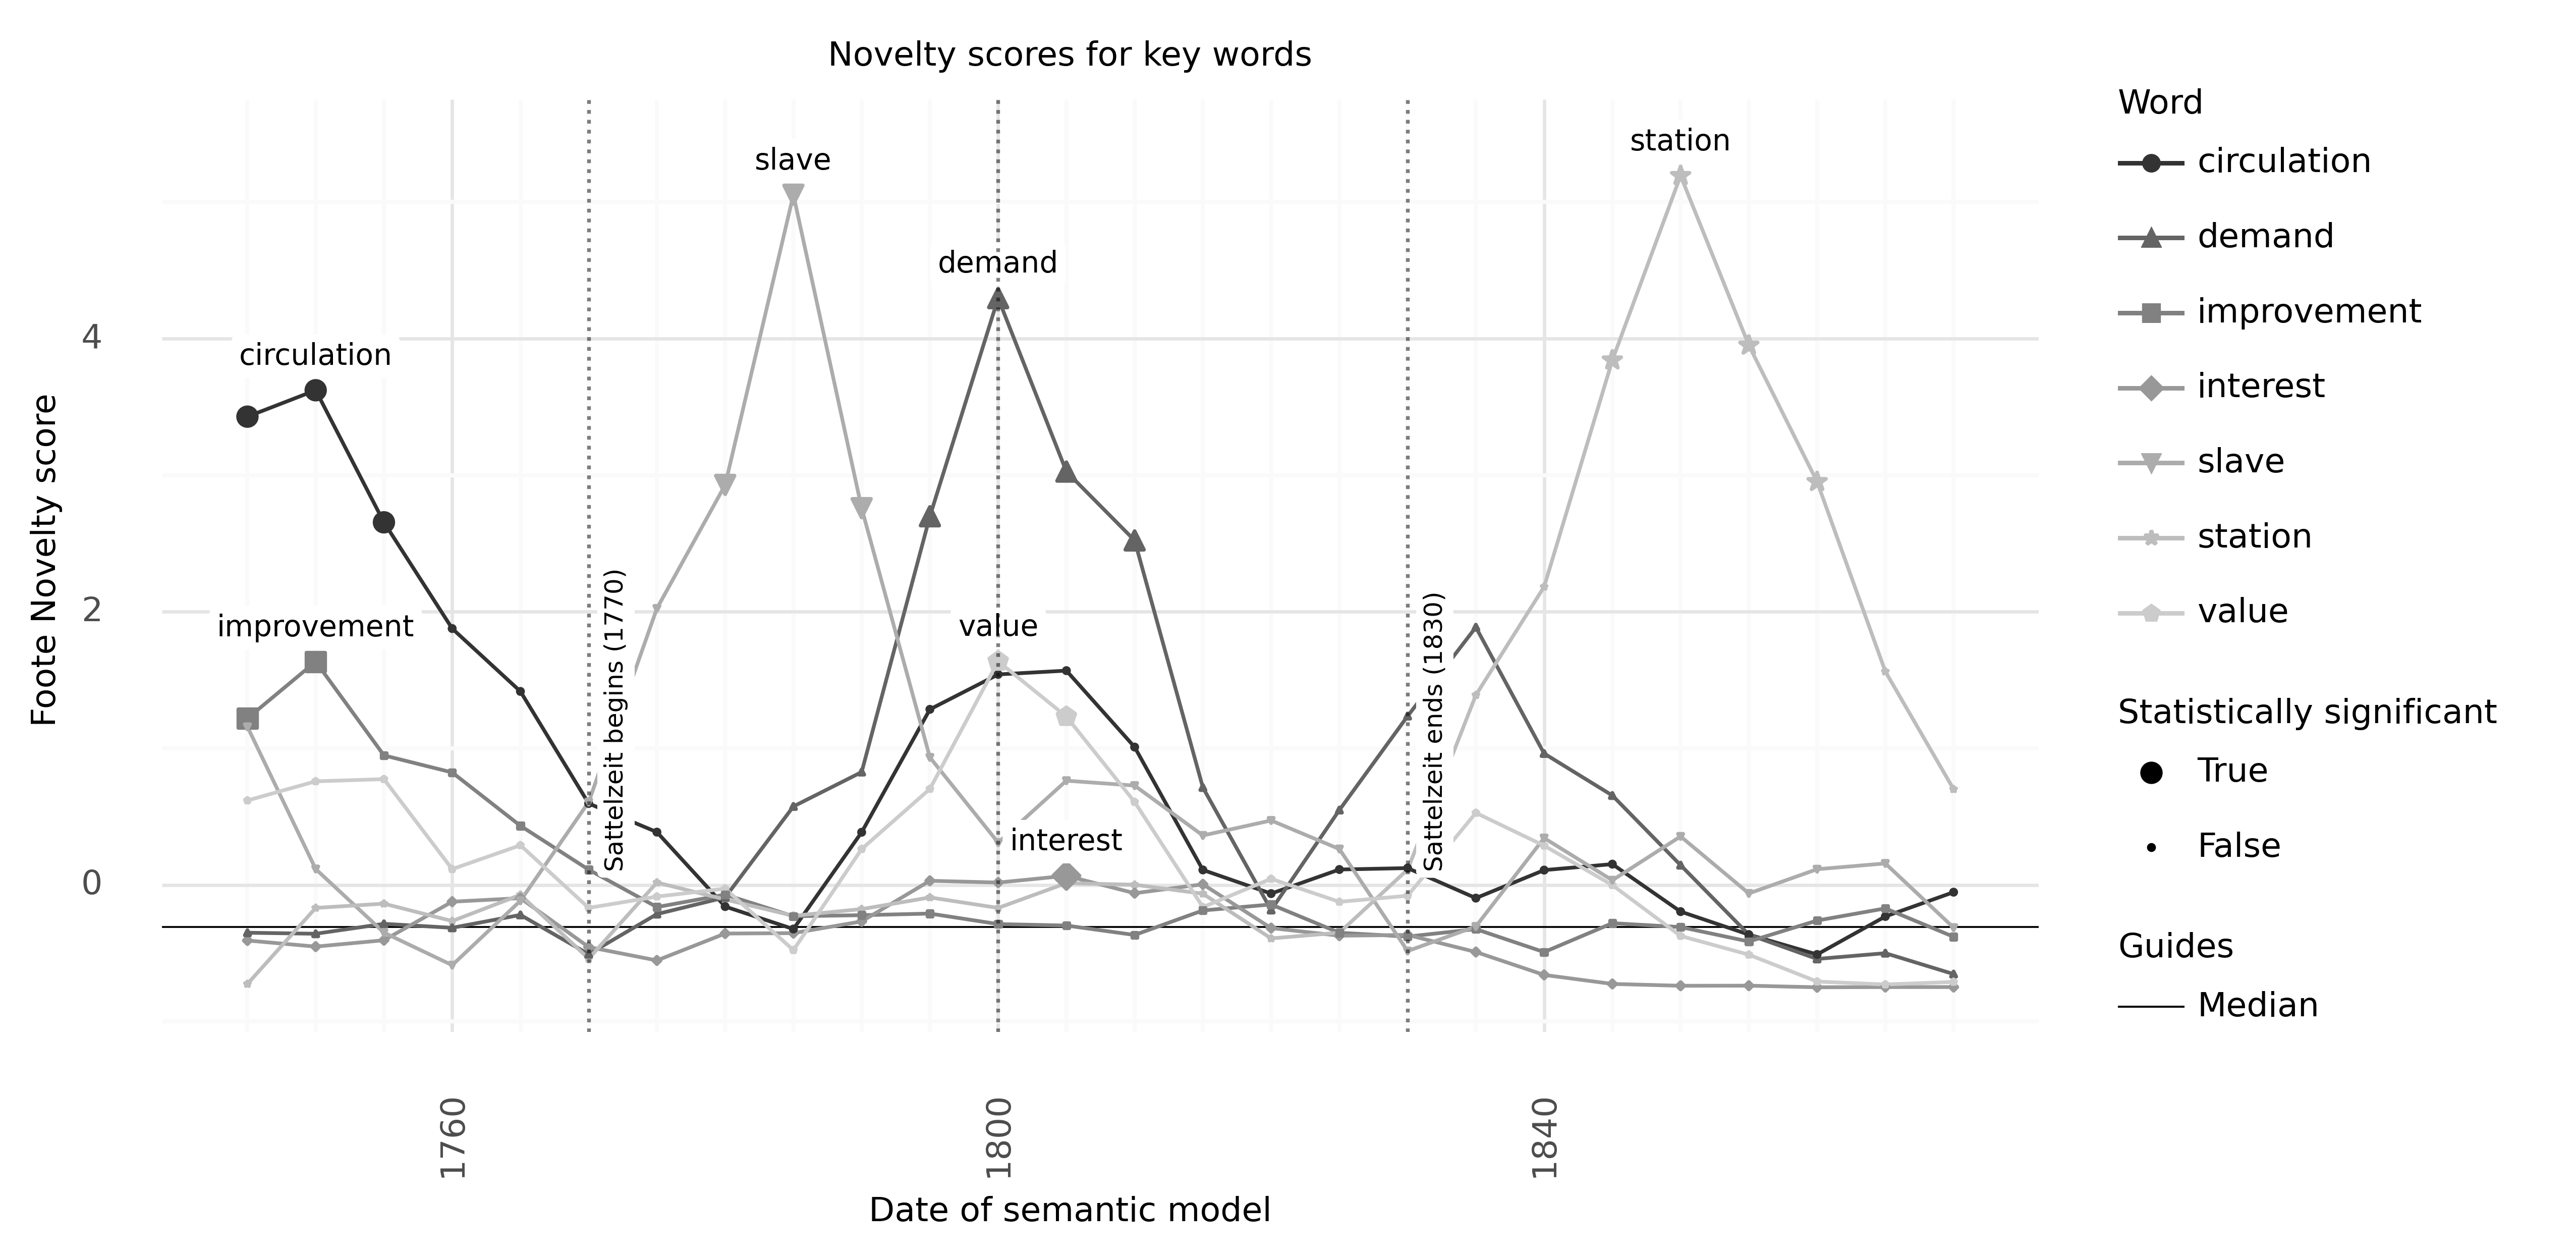

<ggplot: (8784579937569)>

In [8]:
# plot_novelty_words('station,value,commerce,growth,culture,slave,slavery,god,time,december')
plot_novelty_words('station,value,slave,demand,interest,circulation,improvement')